## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [108]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

date имеет тип данных object

In [109]:
# ваш код здесь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [110]:
# ваш код здесь
data['date']=pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


In [111]:
data_min = data.groupby('group')['date'].min()
data_max = data.groupby('group')['date'].max()
print(data_min,data_max)

group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns] group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]


In [112]:
data.groupby('group')['user_id'].count()

group
A    147202
B    147276
Name: user_id, dtype: int64

In [113]:
data.groupby('group')['purchase'].sum()

group
A    17723
B    17514
Name: purchase, dtype: int64

In [114]:
data.groupby('group')['price'].sum()/1000000

group
A    1436.26
B    1554.10
Name: price, dtype: float64

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [115]:
# ваш код здесь
print(data['user_id'].count(),"количество посетителей")
print(data['purchase'].sum(), "количество покупок")
print(data['price'].sum()/1000000,"млн руб")

294478 количество посетителей
35237 количество покупок
2990.36 млн руб


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [116]:
# ваш код здесь
A=set(data[data['group']=='A']['user_id'])
B=set(data[data['group']=='B']['user_id'])

user_intersection = A.intersection(B) 

len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [117]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

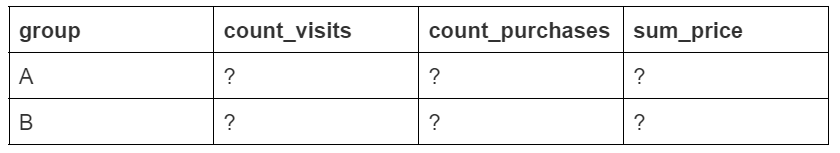
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [118]:
# ваш код здесь

data2=updated_data.groupby('group', as_index=False).agg(
    count_visits=('purchase','count'),
    count_purchases=('purchase','sum'),
    sum_price=('price','sum'),
)
data2

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество посещений в обоих группах потчи одинаково, выборки сбалансирваны.

ваши выводы здесь

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [119]:
# ваш код здесь
data2['conversion']=data2['count_purchases']/data2['count_visits']*100
data2['mean_check']=data2['sum_price']/data2['count_purchases']
data2

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

ваши выводы здесь

Несмотря на то, что конверсия у группы А выше, в группе В выше средний чек. Насколько это статически значимо не ясно.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [120]:
updated_data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


In [121]:
# ваш код здесь
pivot = updated_data.pivot_table(
    values='purchase',
    index='group',
    columns= 'price',
    aggfunc='sum',
    fill_value=0
)

pivot

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

в группе А 5271, в группе В 1730

In [122]:
# ваш код здесь
import plotly.express as px
fig = px.imshow(pivot, color_continuous_scale='reds',title='Зависимость количества прданных туров от направления по группам')
fig.show() 

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

И тепловой карты видно, что туры в Санкт-Петербург, Камчатку и Мальдивы одинакоово распределены по группам, существенное отличие в том, что в группе А в 3 раза чаще покупают туры в Турцию, а в группе настолько же туры в Таиланд.

ваши выводы здесь

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [123]:
# ваш код здесь
data3=updated_data.groupby(['date','group'],as_index=False).agg(
    count_visits=('purchase','count'),
    count_purchases=('purchase','sum'),
    sum_price=('price','sum')
)
data3['conversion']=data3['count_purchases']/data3['count_visits']*100
data3['mean_check']=data3['sum_price']/data3['count_purchases']
data3

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270
5,2021-01-04,B,6536,764,68030000,11.689106,89044.502618
6,2021-01-05,A,6433,790,64550000,12.280429,81708.860759
7,2021-01-05,B,6511,749,63550000,11.503609,84846.461949
8,2021-01-06,A,6606,764,63410000,11.565244,82997.382199
9,2021-01-06,B,6751,838,75020000,12.412976,89522.673031


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [124]:
# ваш код здесь
data3['cum_count_visits'] = data3.groupby(['group'])['count_visits'].cumsum()
data3['cum_count_purchases'] = data3.groupby(['group'])['count_purchases'].cumsum()
data3['cum_sum_price'] = data3.groupby(['group'])['sum_price'].cumsum()
data3['cum_conversion']=data3['cum_count_purchases']/data3['cum_count_visits']*100
data3['cum_mean_check']=data3['cum_sum_price']/data3['cum_count_purchases']


In [125]:
data3

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530
5,2021-01-04,B,6536,764,68030000,11.689106,89044.502618,16016,1863,163650000,11.632118,87842.190016
6,2021-01-05,A,6433,790,64550000,12.280429,81708.860759,22449,2696,220210000,12.009444,81680.267062
7,2021-01-05,B,6511,749,63550000,11.503609,84846.461949,22527,2612,227200000,11.594975,86983.154671
8,2021-01-06,A,6606,764,63410000,11.565244,82997.382199,29055,3460,283620000,11.908449,81971.098266
9,2021-01-06,B,6751,838,75020000,12.412976,89522.673031,29278,3450,302220000,11.783592,87600.000000


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

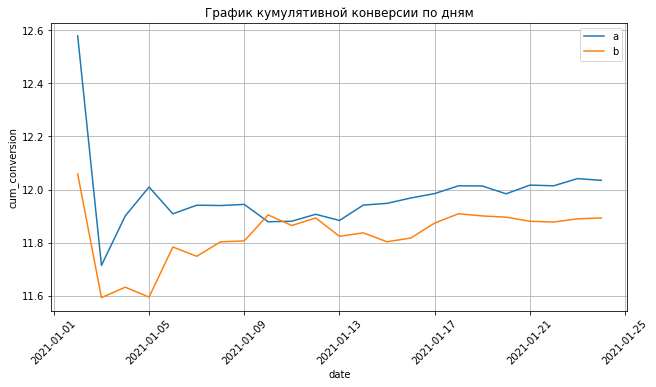

In [126]:
# ваш код здесь
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=data3[data3['group']=='A'], label='a',  ax=ax)
sns.lineplot(x='date', y='cum_conversion', data=data3[data3['group']=='B'], label='b', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

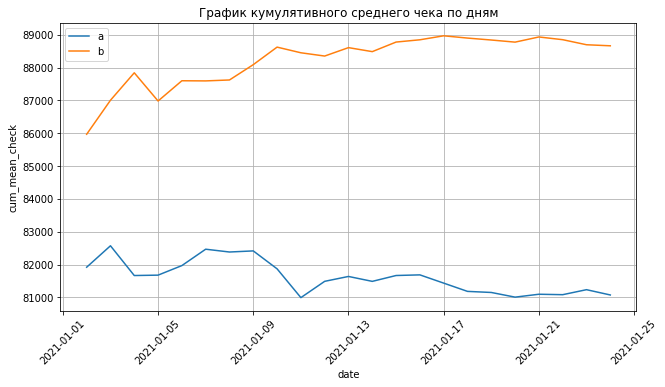

In [128]:
# ваш код здесь
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=data3[data3['group']=='A'], label='a',  ax=ax)
sns.lineplot(x='date', y='cum_mean_check', data=data3[data3['group']=='B'], label='b', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

Значение конверсии и среднегоо чека стабилизировались со временемю В группе В конверсия почти все время ниже, чем в группе А. Со средним чекм наооброт. Выводы поока сделать нельзя, непоонятно насклько эта разница статистиески значима.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [130]:
# ваш код здесь$
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
H_0='Конверсии в группах А и B равны' 
H_1='Конверсия в группе А больше чем конверсия в группе B'
alpha = 0.05
from scipy.stats import shapiro
data4= data3.pivot_table(
    values='conversion', 
    index='date', 
    columns= 'group',
    #aggfunc='sum',
    fill_value=0
)
_, p = shapiro(data4)
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)
 
from statsmodels.stats.weightstats import ztest
def z_test(df):
    print('\n' + "*** Результаты независимого Z-теста ***")
    test_results = ztest(data4['A'], data4['B'])

    p = round(test_results[1],2)

    if p>alpha:
        print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H_0}")
    else:
        print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу. {H_1}")

z_test(data4)

p=0.412
Данные распределены нормально

*** Результаты независимого Z-теста ***
0.22 > 0.05. Мы не можем отвергнуть нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Разница между конверсиями в рамках статистиеской погрешности.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [155]:
# ваш код здесь
def confidence_interval(n,x_mean,sigma,gamma):
    # n размер выборки
    # x_mean выборочное среднее
    # sigma истинное стандартное отклонение
    # gamma уровень надёжности
    alpha = 1 - gamma # уровень значимости
    from scipy.stats import norm
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * sigma/(n ** 0.5) #погрешность
    lower_bound = (x_mean - eps) # левая (нижняя) граница
    upper_bound = (x_mean + eps) # правая (верхняя) граница
    confidence_interval = (lower_bound, upper_bound) # создаём кортеж из округлённых границ интервала
    print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

confidence_interval(data4['A'].count(),data4['A'].mean(),data4['A'].std(),0.95)
confidence_interval(data4['B'].count(),data4['B'].mean(),data4['B'].std(),0.95)

data4['diff']=data4['A']-data4['B']
confidence_interval(data4['diff'].count(),data4['diff'].mean(),data4['diff'].std(),0.95)

Доверительный интервал: (11.884846953938554, 12.201792772600994)
Доверительный интервал: (11.730170569137433, 12.065278942481937)
Доверительный интервал: (-0.07028065849119411, 0.3614708734113714)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительный интервал группы А включен в доверительный интервалгруппы В. Так как доверительный интервал разницы конверсий включает 0 и его небольшую окрестность, кажется что статистической разницы между конверсиями нет.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [166]:
# ваш код здесь
# ваш код здесь$
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'


alpha = 0.05
from scipy.stats import shapiro
data4= data3.pivot_table(
    values='mean_check', 
    index='date', 
    columns= 'group',
    #aggfunc='sum',
    fill_value=0
)
_, p = shapiro(data4)
print('p=%.3f' % p)

# Интерпретация 
if p > alpha:
	print(H0)
else:
	print(Ha)
 



p=0.350
Данные распределены нормально


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [167]:
# ваш код здесь
H_0= 'Ежедневные средние чеки в группах А и B равны'
H_1= 'Ежедневный средний чек в группе А меньше чем в группе B'
from scipy.stats import ttest_ind
def t_test(df):
    print('\n' + "*** Результаты независимого T-теста ***")
    test_results = ttest_ind(df['A'], df['B'], equal_var=True)

    p = round(test_results[1],2)

    if p>alpha:
        print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H_0}")
    else:
        print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу. {H_1}")

t_test(data4)



*** Результаты независимого T-теста ***
0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Есть статистиеская разница между средними чеками в группах. В группе В он больше.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [171]:
def confidence_interval(n,x_mean,sigma,gamma):
    # n размер выборки
    # x_mean выборочное среднее
    # sigma истинное стандартное отклонение
    # gamma уровень надёжности
    alpha = 1 - gamma # уровень значимости
    from scipy.stats import norm
    z_crit = -t.ppf(alpha/2,n-1) # z критическое
    eps = z_crit * sigma/(n ** 0.5) #погрешность
    lower_bound = (x_mean - eps) # левая (нижняя) граница
    upper_bound = (x_mean + eps) # правая (верхняя) граница
    confidence_interval = (lower_bound, upper_bound) # создаём кортеж из округлённых границ интервала
    print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
# ваш код здесь
confidence_interval(data4['A'].count(),data4['A'].mean(),data4['A'].std(),0.95)
confidence_interval(data4['B'].count(),data4['B'].mean(),data4['B'].std(),0.95)

data4['diff']=data4['A']-data4['B']
confidence_interval(data4['diff'].count(),data4['diff'].mean(),data4['diff'].std(),0.95)

Доверительный интервал: (79630.35138233882, 82308.21881567157)
Доверительный интервал: (87625.82583631018, 89525.6051909103)
Доверительный интервал: (-9192.330260127032, -6020.5305690830655)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Средний чек в группе В выше, этостатистически значимо. Доверительные интервалы групп не пересекаются, доверительный интервал разницы не содержит 0. 

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Дизайна посадочной страницы В является более эффективным при равной конверсии групп, средний ччек группы В статистически больше, значит что-то в дизайне вызывает желание больше траить на отдых.